model architecture and partial implementations as shown in: https://github.com/UdbhavPrasad072300/Transformer-Implementations

In [1]:
import sys
from itertools import groupby

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data_utils
import torchvision.transforms.functional as TF
from colorama import Fore
from torchvision import datasets, transforms
from tqdm.notebook import tqdm
import math


In [2]:
gpu = torch.device('cpu')

In [95]:
# ============================================= PREPARING DATASET ======================================================
epochs = 15
num_classes = 11
blank_label = 10
image_height = 28
gru_hidden_size = 128
gru_num_layers = 2
cnn_output_height = 4
cnn_output_width = 32
digits_per_sequence = 5
number_of_sequences = 10000
emnist_dataset = datasets.EMNIST('./EMNIST', split="digits", train=True, download=True)
dataset_sequences = []
dataset_labels = []

for i in range(number_of_sequences):
    random_indices = np.random.randint(len(emnist_dataset.data), size=(digits_per_sequence,))
    random_digits_images = emnist_dataset.data[random_indices]
    transformed_random_digits_images = []

    for img in random_digits_images:
        img = transforms.ToPILImage()(img)
        img = TF.rotate(img, -90, fill=0)
        img = TF.hflip(img)
        img = transforms.RandomAffine(degrees=10, translate=(0.2, 0.15), scale=(0.8, 1.1))(img)
        img = transforms.ToTensor()(img).unsqueeze(0)
        transformed_random_digits_images.append(img)

    random_digits_images = np.array(transformed_random_digits_images)
    random_digits_labels = emnist_dataset.targets[random_indices]
    random_sequence = np.hstack(random_digits_images.reshape((digits_per_sequence, 28, 28)))
    random_labels = np.hstack(random_digits_labels.reshape(digits_per_sequence, 1))
    dataset_sequences.append(random_sequence / 255)
    dataset_labels.append(random_labels)

dataset_data = torch.Tensor(np.array(dataset_sequences))
dataset_labels = torch.IntTensor(np.array(dataset_labels))

seq_dataset = data_utils.TensorDataset(dataset_data, dataset_labels)
train_set, val_set = torch.utils.data.random_split(seq_dataset,
                                                   [int(len(seq_dataset) * 0.8), int(len(seq_dataset) * 0.2)])

train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=1, shuffle=True)


In [4]:
# ================================================= MODEL ==============================================================
class CRNN(nn.Module):

    def __init__(self):
        super(CRNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=(3, 3))
        self.norm1 = nn.InstanceNorm2d(32)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=(3, 3), stride=2)
        self.norm2 = nn.InstanceNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=(3, 3))
        self.norm3 = nn.InstanceNorm2d(64)
        self.conv4 = nn.Conv2d(64, 64, kernel_size=(3, 3), stride=2)
        self.norm4 = nn.InstanceNorm2d(64)
        self.gru_input_size = cnn_output_height * 64
        self.gru = nn.GRU(self.gru_input_size, gru_hidden_size, gru_num_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(gru_hidden_size * 2, num_classes)

    def forward(self, x):
        batch_size = x.shape[0]
        out = self.conv1(x)
        out = self.norm1(out)
        out = F.leaky_relu(out)
        out = self.conv2(out)
        out = self.norm2(out)
        out = F.leaky_relu(out)
        out = self.conv3(out)
        out = self.norm3(out)
        out = F.leaky_relu(out)
        out = self.conv4(out)
        out = self.norm4(out)
        out = F.leaky_relu(out)
        out = out.permute(0, 3, 2, 1)
        out = out.reshape(batch_size, -1, self.gru_input_size)
        out, _ = self.gru(out)
        out = torch.stack([F.log_softmax(self.fc(out[i]), dim=-1) for i in range(out.shape[0])])
        return out


model = CRNN().to(gpu)
criterion = nn.CTCLoss(blank=blank_label, reduction='mean', zero_infinity=True)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [5]:
class MultiHeadAttention(nn.Module):

    def __init__(self, embed_size: int, num_heads: int, dropout: float = 0.2, batch_dim: int = 0):
        super(MultiHeadAttention, self).__init__()

        self.embed_size = embed_size
        self.num_heads = num_heads
        self.dropout = dropout
        self.batch_dim = batch_dim

        self.dropout_layer = nn.Dropout(dropout)

        self.head_size = self.embed_size // self.num_heads

        assert self.head_size * self.num_heads == self.embed_size, "Heads cannot split Embedding size equally"

        self.Q = nn.Linear(self.embed_size, self.embed_size)
        self.K = nn.Linear(self.embed_size, self.embed_size)
        self.V = nn.Linear(self.embed_size, self.embed_size)

        self.linear = nn.Linear(self.embed_size, self.embed_size)

    def forward(self, q, k, v, mask=None):
        if self.batch_dim == 0:
            out = self.batch_0(q, k, v, mask)
        elif self.batch_dim == 1:
            out = self.batch_1(q, k, v, mask)

        return out

    def batch_0(self, q, k, v, mask=None):
        q_batch_size, q_seq_len, q_embed_size = q.size()
        k_batch_size, k_seq_len, k_embed_size = k.size()
        v_batch_size, v_seq_len, v_embed_size = v.size()

        q = self.Q(q).reshape(q_batch_size, q_seq_len, self.num_heads, self.head_size)
        k = self.K(k).reshape(k_batch_size, k_seq_len, self.num_heads, self.head_size)
        v = self.V(v).reshape(v_batch_size, v_seq_len, self.num_heads, self.head_size)

        attention = self.attention(q, k, v, mask=mask)
        concatenated = attention.reshape(v_batch_size, -1, self.embed_size)
        out = self.linear(concatenated)

        return out

    def batch_1(self, q, k, v, mask=None):
        q_seq_len, q_batch_size, q_embed_size = q.size()
        k_seq_len, k_batch_size, k_embed_size = k.size()
        v_seq_len, v_batch_size, v_embed_size = v.size()

        q = self.Q(q).reshape(q_seq_len, q_batch_size, self.num_heads, self.head_size).transpose(0, 1)
        k = self.K(k).reshape(k_seq_len, k_batch_size, self.num_heads, self.head_size).transpose(0, 1)
        v = self.V(v).reshape(v_seq_len, v_batch_size, self.num_heads, self.head_size).transpose(0, 1)

        attention = self.attention(q, k, v, mask=mask)
        concatenated = attention.reshape(-1, v_batch_size, self.embed_size)

        out = self.linear(concatenated)

        return out

    def attention(self, q, k, v, mask=None):
        scores = torch.einsum("bqhe,bkhe->bhqk", [q, k])

        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)

        scores /= math.sqrt(self.embed_size)
        scores = F.softmax(scores, dim=-1)
        scores = self.dropout_layer(scores)
        attention = torch.einsum("bhql,blhd->bqhd", [scores, v])
        return attention

In [6]:
class VisionEncoder(nn.Module):

    def __init__(self, embed_size: int, num_heads: int, hidden_size: int, dropout: float = 0.1):
        super(VisionEncoder, self).__init__()

        self.embed_size = embed_size
        self.num_heads = num_heads
        self.hidden_size = hidden_size
        self.dropout = dropout

        self.norm1 = nn.LayerNorm(self.embed_size)
        self.norm2 = nn.LayerNorm(self.embed_size)

        self.attention = MultiHeadAttention(self.embed_size, self.num_heads, dropout=dropout)

        self.mlp = nn.Sequential(
            nn.Linear(self.embed_size, 4 * self.embed_size),
            nn.GELU(),
            nn.Dropout(self.dropout),
            nn.Linear(4 * self.embed_size, self.embed_size),
            nn.Dropout(self.dropout)
        )

    def forward(self, x):
        x = self.norm1(x)
        x = x + self.attention(x, x, x)
        x = x + self.mlp(self.norm2(x))
        return x

In [8]:
BATCH_SIZE = 64
LR = 5e-4
NUM_EPOCHES = 15

In [10]:
mean, std = (0.5,), (0.5,)

transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize(mean, std)
                              ])

In [11]:
emnist_dataset = datasets.EMNIST('./EMNIST', train=True, download=False, split="digits", transform=transform)
#emnist_dataset = datasets.MNIST('./data/MNIST/', download=False, train=False, transform=transform)


trainloader = torch.utils.data.DataLoader(emnist_dataset, batch_size=BATCH_SIZE, shuffle=True)
testloader = torch.utils.data.DataLoader(emnist_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [101]:
class ViT_sequence(nn.Module):

    def __init__(self, image_height: int, image_width: int, channel_size: int, patch_height: int, patch_width: int,
                 embed_size: int, num_heads: int, num_classes: int, num_layers: int, hidden_size: int, dropout: float = 0.1):
        super(ViT_sequence, self).__init__()

        self.patch_height = patch_height
        self.patch_width = patch_width
        self.image_height = image_height
        self.image_width = image_width
        self.embed_size = embed_size
        self.num_patches = (image_height // patch_height) * (image_width // patch_width)
        self.patch_size = channel_size * (patch_height * patch_width)
        self.num_heads = num_heads
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.dropout = dropout
        self.dropout_layer = nn.Dropout(dropout)

        self.embeddings = nn.Linear(self.patch_size, self.embed_size)
        self.class_token = nn.Parameter(torch.randn(1, 1, self.embed_size))
        self.positional_encoding = nn.Parameter(torch.randn(1, self.num_patches + 1, self.embed_size))

        self.encoders = nn.ModuleList([])
        for layer in range(self.num_layers):
            self.encoders.append(VisionEncoder(self.embed_size, self.num_heads, self.hidden_size, self.dropout))

        self.norm = nn.LayerNorm(self.embed_size)

        # Adjusted classifier for each patch
        self.classifier = nn.Linear(self.embed_size, num_classes)

    def forward(self, x, mask=None):
        b, c, h, w = x.size()

        # Embedding and positional encoding
        x = x.reshape(b, int((h / self.patch_height) * (w / self.patch_width)), c * self.patch_height * self.patch_width)
        x = self.embeddings(x)
        b, n, e = x.size()

        class_token = self.class_token.expand(b, 1, e)
        x = torch.cat((x, class_token), dim=1)
        x = self.dropout_layer(x + self.positional_encoding)
        
        # Encoder layers
        for encoder in self.encoders:
            x = encoder(x)

        x = self.classifier(x)  # [batch_size, num_patches + 1, num_classes]

        # Reshape to match CTC loss expectations
        x = x.permute(1, 0, 2)  # [num_patches + 1, batch_size, num_classes]

        return x

In [102]:
image_height = 28
image_width = 140
channel_size = 1
patch_height = 4
patch_width = 20
embed_size = 256
num_heads = 8
seq_len = 5  # Desired output sequence length
num_layers = 12
hidden_size = 512
dropout = 0.1
num_classes = 11


device = torch.device("cpu")
model_seq = ViT_sequence(image_height, image_width, channel_size, patch_height, patch_width, embed_size, num_heads, num_classes, num_layers, hidden_size, dropout=dropout).to(device)
model_seq

ViT_sequence(
  (dropout_layer): Dropout(p=0.1, inplace=False)
  (embeddings): Linear(in_features=80, out_features=256, bias=True)
  (encoders): ModuleList(
    (0-11): 12 x VisionEncoder(
      (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (attention): MultiHeadAttention(
        (dropout_layer): Dropout(p=0.1, inplace=False)
        (Q): Linear(in_features=256, out_features=256, bias=True)
        (K): Linear(in_features=256, out_features=256, bias=True)
        (V): Linear(in_features=256, out_features=256, bias=True)
        (linear): Linear(in_features=256, out_features=256, bias=True)
      )
      (mlp): Sequential(
        (0): Linear(in_features=256, out_features=1024, bias=True)
        (1): GELU(approximate='none')
        (2): Dropout(p=0.1, inplace=False)
        (3): Linear(in_features=1024, out_features=256, bias=True)
        (4): Dropout(p=0.1, inplace=False)
      )
    )
  )
 

In [97]:
for img, label in train_loader:
    img = img.unsqueeze(1)
    label = label.to(device)
    
    print("Input Image Dimensions: {}".format(img.size()))
    print("Label Dimensions: {}".format(label.size()))
    print("-"*100)
    
    out = model_seq(img)
    
    print("Output Dimensions: {}".format(out.size()))
    break

Input Image Dimensions: torch.Size([64, 1, 28, 140])
Label Dimensions: torch.Size([64, 5])
----------------------------------------------------------------------------------------------------
Output Dimensions: torch.Size([50, 64, 11])


In [98]:
#criterion = nn.NLLLoss()
criterion = nn.CTCLoss(blank=blank_label, reduction='mean', zero_infinity=True)
optimizer = torch.optim.Adam(params=model.parameters(), lr=LR)

In [99]:
# ================================================ TRAINING MODEL ======================================================
for _ in range(epochs):
    # ============================================ TRAINING ============================================================
    train_correct = 0
    train_total = 0
    for x_train, y_train in tqdm(train_loader,
                                 position=0, leave=True,
                                 file=sys.stdout, bar_format="{l_bar}%s{bar}%s{r_bar}" % (Fore.GREEN, Fore.RESET)):
        batch_size = x_train.shape[0]  # x_train.shape == torch.Size([64, 28, 140])
        x_train = x_train.view(x_train.shape[0], 1, x_train.shape[1], x_train.shape[2])
        #print(x_train.shape)
        #print("Y Train: ", y_train.shape)
        optimizer.zero_grad()
        y_pred = model_seq(x_train)
        # y_pred = y_pred.permute(0, 1)  # y_pred.shape == torch.Size([64, 32, 11])
        #print(y_pred.shape)

        # Ensure each prediction is of length 5 by padding or truncating as needed
        for i in range(y_pred.shape[1]):
            raw_prediction = list(y_pred[:, i, :].argmax(dim=1).detach().cpu().numpy())
            # Pad or truncate the prediction to ensure it's of length 5
            if len(raw_prediction) < 5:
                raw_prediction = [0] * (5 - len(raw_prediction)) + raw_prediction
            elif len(raw_prediction) > 5:
                raw_prediction = raw_prediction[:5]
            prediction = torch.IntTensor(raw_prediction)

        input_lengths = torch.IntTensor([x_train.size(3) // patch_width] * batch_size)
        #print(input_lengths.shape)
        target_lengths = torch.IntTensor([len(t) for t in y_train])
        loss = criterion(y_pred, y_train, input_lengths, target_lengths)
        loss.backward()
        optimizer.step()
        _, max_index = torch.max(y_pred, dim=2)  # max_index.shape == torch.Size([32, 64])
        for i in range(batch_size):
            raw_prediction = list(max_index[:, i].detach().cpu().numpy())  # len(raw_prediction) == 32
            prediction = torch.IntTensor([c for c, _ in groupby(raw_prediction) if c != blank_label])
            if len(prediction) == len(y_train[i]) and torch.all(prediction.eq(y_train[i])):
                train_correct += 1
            train_total += 1
    print('TRAINING. Correct: ', train_correct, '/', train_total, '=', train_correct / train_total)

  0%|          | 0/125 [00:00<?, ?it/s]

TRAINING. Correct:  0 / 8000 = 0.0


  0%|          | 0/125 [00:00<?, ?it/s]

TRAINING. Correct:  0 / 8000 = 0.0


  0%|          | 0/125 [00:00<?, ?it/s]

TRAINING. Correct:  0 / 8000 = 0.0


  0%|          | 0/125 [00:00<?, ?it/s]

TRAINING. Correct:  0 / 8000 = 0.0


  0%|          | 0/125 [00:00<?, ?it/s]

TRAINING. Correct:  0 / 8000 = 0.0


  0%|          | 0/125 [00:00<?, ?it/s]

TRAINING. Correct:  0 / 8000 = 0.0


  0%|          | 0/125 [00:00<?, ?it/s]

TRAINING. Correct:  0 / 8000 = 0.0


  0%|          | 0/125 [00:00<?, ?it/s]

TRAINING. Correct:  0 / 8000 = 0.0


  0%|          | 0/125 [00:00<?, ?it/s]

TRAINING. Correct:  0 / 8000 = 0.0


  0%|          | 0/125 [00:00<?, ?it/s]

TRAINING. Correct:  0 / 8000 = 0.0


  0%|          | 0/125 [00:00<?, ?it/s]

TRAINING. Correct:  0 / 8000 = 0.0


  0%|          | 0/125 [00:00<?, ?it/s]

TRAINING. Correct:  0 / 8000 = 0.0


  0%|          | 0/125 [00:00<?, ?it/s]

TRAINING. Correct:  0 / 8000 = 0.0


  0%|          | 0/125 [00:00<?, ?it/s]

TRAINING. Correct:  0 / 8000 = 0.0


  0%|          | 0/125 [00:00<?, ?it/s]

TRAINING. Correct:  0 / 8000 = 0.0


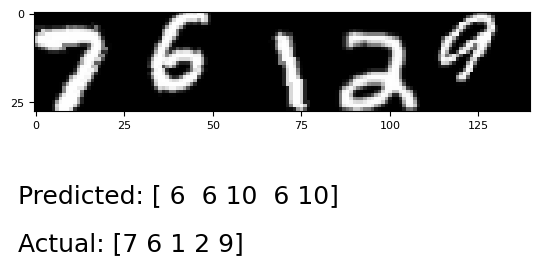

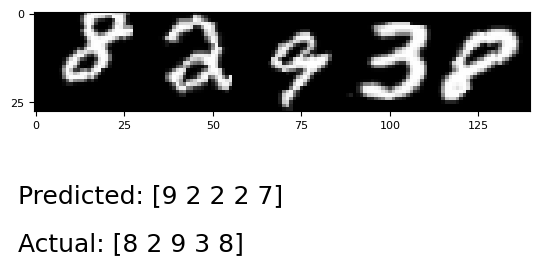

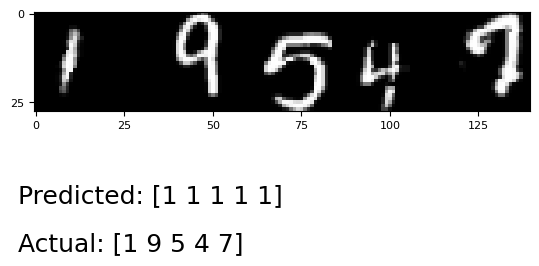

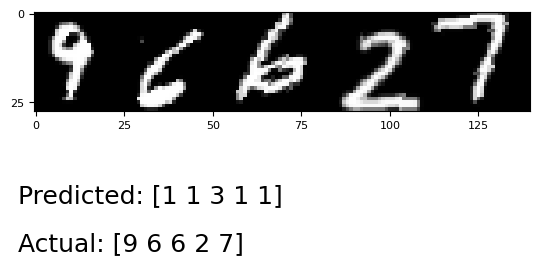

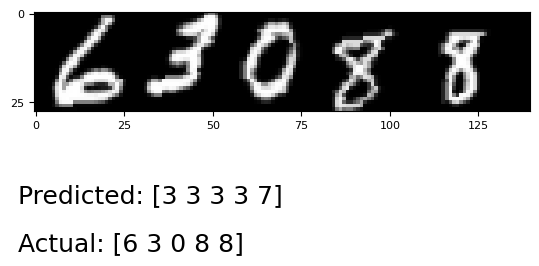

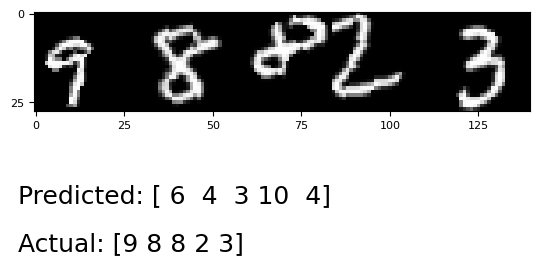

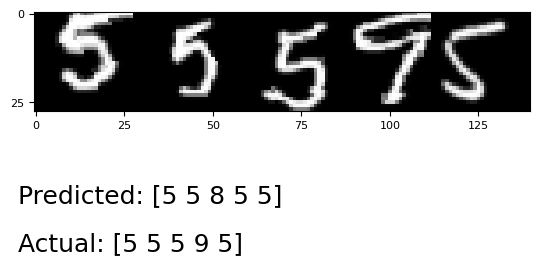

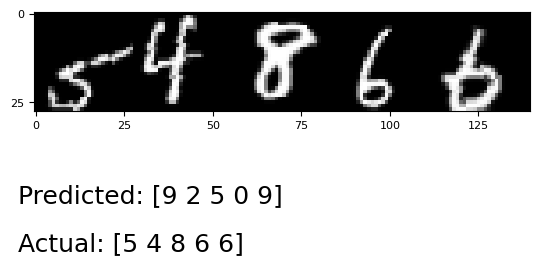

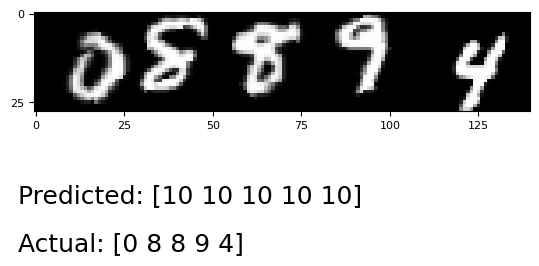

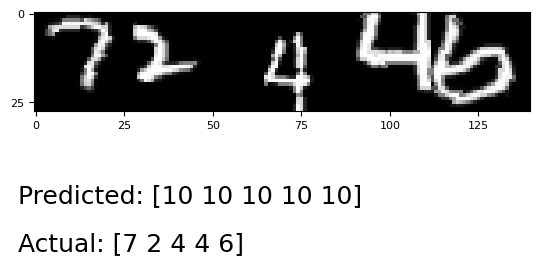

In [100]:
# ============================================ TESTING =================================================================
number_of_test_imgs = 10
test_loader = torch.utils.data.DataLoader(val_set, batch_size=number_of_test_imgs, shuffle=True)
test_preds = []
(x_test, y_test) = next(iter(test_loader))
y_pred = model_seq(x_test.view(x_test.shape[0], 1, x_test.shape[1], x_test.shape[2]))
y_pred = y_pred.permute(1, 0, 2)

# Ensure each prediction is of length 5 by padding or truncating as needed
for i in range(y_pred.shape[1]):
    raw_prediction = list(y_pred[:, i, :].argmax(dim=1).detach().cpu().numpy())
    # Pad or truncate the prediction to ensure it's of length 5
    if len(raw_prediction) < 5:
        raw_prediction = [0] * (5 - len(raw_prediction)) + raw_prediction
    elif len(raw_prediction) > 5:
        raw_prediction = raw_prediction[:5]
    prediction = torch.IntTensor(raw_prediction)
    test_preds.append(prediction)


for j in range(len(x_test)):
    mpl.rcParams["font.size"] = 8
    plt.imshow(x_test[j], cmap='gray')
    mpl.rcParams["font.size"] = 18
    plt.gcf().text(x=0.1, y=0.1, s="Actual: " + str(y_test[j].numpy()))
    plt.gcf().text(x=0.1, y=0.2, s="Predicted: " + str(test_preds[j].numpy()))
    plt.show()

In [ ]:
loss_hist = {}
loss_hist["train accuracy"] = []
loss_hist["train loss"] = []

for epoch in tqdm(range(1, NUM_EPOCHES+1)):
    model.train()
    
    epoch_train_loss = 0
        
    y_true_train = []
    y_pred_train = []

    short = 0
        
    for batch_idx, (img, labels) in enumerate(trainloader):
        short += 1
        if short > 200:
            break

        img = img.to(device)
        labels = labels.to(device)
        
        preds = model(img)
        
        loss = criterion(preds, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        y_pred_train.extend(preds.detach().argmax(dim=-1).tolist())
        y_true_train.extend(labels.detach().tolist())
            
        epoch_train_loss += loss.item()
    
    loss_hist["train loss"].append(epoch_train_loss)
    
    total_correct = len([True for x, y in zip(y_pred_train, y_true_train) if x==y])
    total = len(y_pred_train)
    accuracy = total_correct * 100 / total
    
    loss_hist["train accuracy"].append(accuracy)
    
    print("-------------------------------------------------")
    print("Epoch: {} Train mean loss: {:.8f}".format(epoch, epoch_train_loss))
    print("       Train Accuracy%: ", accuracy, "==", total_correct, "/", total)
    print("-------------------------------------------------")

  0%|          | 0/15 [00:00<?, ?it/s]

-------------------------------------------------
Epoch: 1 Train mean loss: 181.25892772
       Train Accuracy%:  70.34375 == 9004 / 12800
-------------------------------------------------
-------------------------------------------------
Epoch: 2 Train mean loss: 66.98763258
       Train Accuracy%:  89.6015625 == 11469 / 12800
-------------------------------------------------
-------------------------------------------------
Epoch: 3 Train mean loss: 55.50267670
       Train Accuracy%:  91.421875 == 11702 / 12800
-------------------------------------------------
-------------------------------------------------
Epoch: 4 Train mean loss: 48.71538311
       Train Accuracy%:  92.1875 == 11800 / 12800
-------------------------------------------------
-------------------------------------------------
Epoch: 5 Train mean loss: 46.24255319
       Train Accuracy%:  92.6796875 == 11863 / 12800
-------------------------------------------------
-------------------------------------------------
E

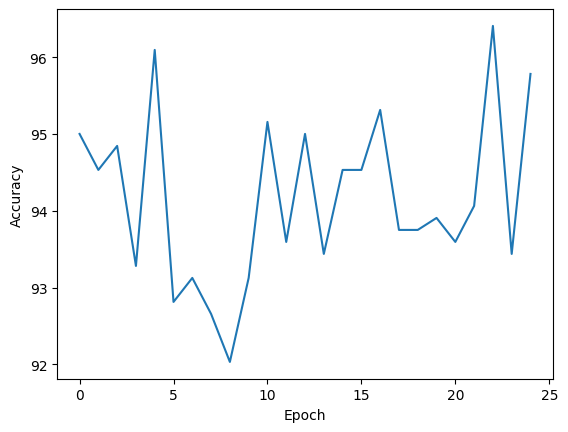

In [65]:
plt.plot(loss_hist["train accuracy"])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

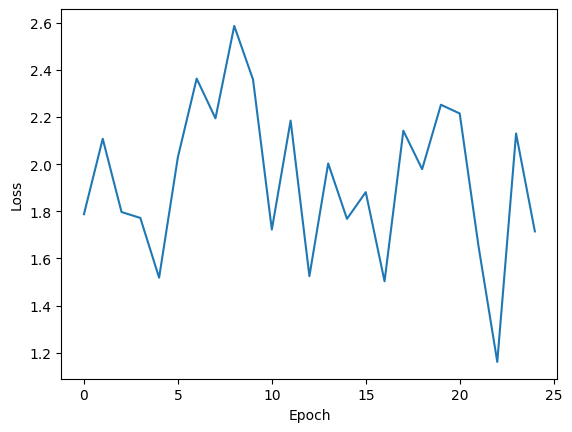

In [64]:
plt.plot(loss_hist["train loss"])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

In [89]:
with torch.no_grad():
    model.eval()
    
    y_true_test = []
    y_pred_test = []
    
    for batch_idx, (img, labels) in tqdm(enumerate(testloader)):
        img = img.to(device)
        labels = labels.to(device)
    
        preds = model(img)
        
        y_pred_test.extend(preds.detach().argmax(dim=-1).tolist())
        y_true_test.extend(labels.detach().tolist())
        
    total_correct = len([True for x, y in zip(y_pred_test, y_true_test) if x==y])
    total = len(y_pred_test)
    accuracy = total_correct * 100 / total
    
    print("Test Accuracy%: ", accuracy, "==", total_correct, "/", total)

0it [00:00, ?it/s]

Test Accuracy%:  95.35333333333334 == 228848 / 240000
